# End-to-End Spam Detection System

## 1. Introduction


### Overview

- **Spam Detection** is a classic classification problem where the goal is to classify messages (typically emails or SMS) as either **"spam"** or **"ham"** (not spam).

- In this notebook, we will build a **spam detection system** using:
  - **Natural Language Processing (NLP)**
  - **Machine Learning techniques**


### Steps Involved

1. **Data Loading and Exploration**
2. **Data Preprocessing**
3. **Feature Extraction (TF-IDF)**
4. **Model Training and Evaluation**
5. **Hyperparameter Tuning**
6. **Final Model and Prediction**


## 2. Data Loading and Exploration


### Loading the Data

- We will use a publicly available **SMS Spam Collection dataset**.
- This dataset contains a collection of SMS messages labeled as **"spam"** or **"ham"** (not spam).


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])

# Display the first few rows of the dataset
df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Data Exploration

- Let's explore the data to understand its **structure** and **distribution**.


In [ ]:
print(df.shape)

(5572, 2)


Missing values: 
label      0
message    0
dtype: int64


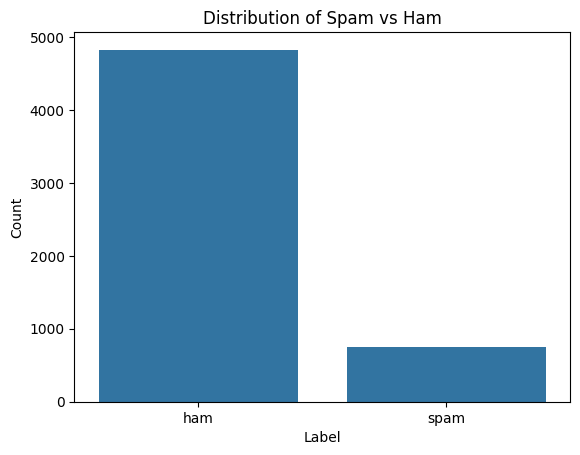

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4825.0,71.482487,58.440652,2.0,33.0,52.0,93.0,910.0
spam,747.0,138.670683,28.873603,13.0,133.0,149.0,157.0,223.0


In [ ]:
# Check for missing values
print(f"Missing values: \n{df.isnull().sum()}")

# Distribution of labels
sns.countplot(data=df, x='label')
plt.title("Distribution of Spam vs Ham")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Display basic statistics
df['message_length'] = df['message'].apply(len)
df.groupby('label')['message_length'].describe()


### Insights

- The dataset contains two classes: **"spam"** and **"ham"**.
- We observe that the number of **"ham"** messages is significantly higher than the number of **"spam"** messages, indicating a **class imbalance**.


## 3. Data Preprocessing


### Text Preprocessing

Text data needs to be cleaned and preprocessed before feeding it into a machine learning model. Common preprocessing steps include:

- **Lowercasing**: Converting all characters to lowercase.
- **Removing Punctuation**: Removing special characters and punctuation.
- **Tokenization**: Splitting text into words.
- **Stopword Removal**: Removing common words that do not contribute to the meaning (e.g., "and", "the").
- **Lemmatization**: Reducing words to their base form (e.g., "running" to "run").


In [ ]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to the messages
df['cleaned_message'] = df['message'].apply(preprocess_text)

# Display the first few cleaned messages
df[['message', 'cleaned_message']].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,message,cleaned_message
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


## 4. Feature Extraction (TF-IDF)


### TF-IDF Vectorization

- **TF-IDF (Term Frequency-Inverse Document Frequency)** is a common technique used to convert text data into numerical features.
- TF-IDF reflects the importance of a word in a document relative to the entire corpus.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=3000)

# Fit and transform the cleaned text
X = tfidf.fit_transform(df['cleaned_message']).toarray()

# Target variable
y = df['label'].map({'ham': 0, 'spam': 1}).values

# Display the shape of the TF-IDF matrix
print(f"TF-IDF matrix shape: {X.shape}")


TF-IDF matrix shape: (5572, 3000)


## 5. Model Training and Evaluation


### Model Selection

- We will train several classification models to predict whether an SMS message is **"spam"** or **"ham"**.
- The models include:
  - **Logistic Regression**
  - **Naive Bayes**
  - **K-Nearest Neighbors (K-NN)**
  - **Support Vector Machine (SVM)**


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Naive Bayes": MultinomialNB(),
    "K-NN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel='linear')
}

# Train and evaluate the models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("\n" + "-"*50 + "\n")


Logistic Regression Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1448
           1       0.98      0.75      0.85       224

    accuracy                           0.96      1672
   macro avg       0.97      0.87      0.91      1672
weighted avg       0.96      0.96      0.96      1672

[[1444    4]
 [  56  168]]

--------------------------------------------------

Naive Bayes Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       1.00      0.86      0.92       224

    accuracy                           0.98      1672
   macro avg       0.99      0.93      0.96      1672
weighted avg       0.98      0.98      0.98      1672

[[1448    0]
 [  32  192]]

--------------------------------------------------

K-NN Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      

## 6. Hyperparameter Tuning


### Hyperparameter Tuning with Grid Search

- To improve model performance, we can fine-tune the hyperparameters using **Grid Search with Cross-Validation**.


In [ ]:
from sklearn.model_selection import GridSearchCV

# Example: Tuning hyperparameters for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear']
}

# Create a GridSearchCV object
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')
grid_svm.fit(X_train, y_train)

# Best parameters and best score
print(f"Best SVM parameters: {grid_svm.best_params_}")
print(f"Best SVM accuracy: {grid_svm.best_score_:.2f}")


Best SVM parameters: {'C': 1, 'kernel': 'linear'}
Best SVM accuracy: 0.98


## 7. Final Model and Prediction


### Selecting the Final Model

- Based on the evaluation, we will:
  - Select the **best-performing model**.
  - Use this model to make predictions on **new data**.


In [ ]:
# Using the best SVM model for final predictions
final_model = grid_svm.best_estimator_

# Predicting on the test set
y_final_pred = final_model.predict(X_test)

# Evaluate final model performance
final_accuracy = accuracy_score(y_test, y_final_pred)
print(f"Final Model Accuracy: {final_accuracy:.2f}")

# Confusion matrix and classification report
print("\nFinal Model Confusion Matrix:")
print(confusion_matrix(y_test, y_final_pred))
print("\nFinal Model Classification Report:")
print(classification_report(y_test, y_final_pred))


Final Model Accuracy: 0.98

Final Model Confusion Matrix:
[[1445    3]
 [  23  201]]

Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       0.99      0.90      0.94       224

    accuracy                           0.98      1672
   macro avg       0.98      0.95      0.97      1672
weighted avg       0.98      0.98      0.98      1672



### Predicting on New Messages

- Let's simulate predicting whether new SMS messages are **spam** or **ham**.


In [ ]:
# New SMS messages
new_messages = ["Congratulations! You've won a free ticket to Bahamas. Call now!",
                "Are we meeting for lunch today?",
                "URGENT! Your account has been compromised. Contact us immediately."]

# Preprocess the new messages
new_messages_cleaned = [preprocess_text(msg) for msg in new_messages]

# Transform the new messages using TF-IDF
new_messages_tfidf = tfidf.transform(new_messages_cleaned).toarray()

# Predict using the final model
new_predictions = final_model.predict(new_messages_tfidf)

# Display the predictions
for i, message in enumerate(new_messages):
    print(f"Message: {message}")
    print(f"Prediction: {'Spam' if new_predictions[i] == 1 else 'Ham'}")
    print("-" * 50)


Message: Congratulations! You've won a free ticket to Bahamas. Call now!
Prediction: Spam
--------------------------------------------------
Message: Are we meeting for lunch today?
Prediction: Ham
--------------------------------------------------
Message: URGENT! Your account has been compromised. Contact us immediately.
Prediction: Spam
--------------------------------------------------


## 8. Conclusion


### Recap

- In this notebook, we built a complete **end-to-end spam detection system** using natural language processing and machine learning techniques.
- We covered:
  - **Data loading**
  - **Data preprocessing**
  - **Feature extraction using TF-IDF**
  - **Model training**
  - **Model evaluation**
  - **Hyperparameter tuning**
  - **Selecting the final model**
  - **Predicting on new messages**


In [ ]:
# Initialize the models
# classifier = SVC(kernel='linear', probability=True)
# classifier.fit(X_train, y_train)


In [ ]:
import numpy as np

# Define a custom threshold
# custom_threshold = 0.05  # Adjust this value as needed
# y_probs = classifier.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# # Generate predictions based on the custom threshold
# y_pred_custom = np.where(y_probs >= custom_threshold, 1, 0)

# # Evaluate the new predictions
# from sklearn.metrics import confusion_matrix, classification_report

# print(confusion_matrix(y_test, y_pred_custom))
# print(classification_report(y_test, y_pred_custom))


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot the confusion matrix
# ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, cmap='Blues')

# plt.title('Confusion Matrix')
# plt.show()